In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
machine_meta = pd.read_csv('data/machine_meta.csv', header=None,
                           names=['machine_id','time_stamp','failure_domain_1',
                                  'failure_domain_2','cpu_num','mem_size','status'])
machine_meta.head()

,machine_id,time_stamp,failure_domain_1,failure_domain_2,cpu_num,mem_size,status
0,m_1,0,219,17.0,96,100,USING
1,m_1,148984,219,17.0,96,100,USING
2,m_1,535156,219,17.0,96,100,USING
3,m_1,552384,219,17.0,96,100,USING
4,m_1,658423,219,17.0,96,100,USING


Large File - Reading only 10,000,000 rows for now


In [5]:
machine_usage = pd.read_csv('data/machine_usage.csv', header=None, nrows=10000000, 
                            names=['machine_id','time_stamp','cpu_util_percent',
                                   'mem_util_percent','mem_gps','mkpi','net_in',
                                   'net_out','disk_io_percent'])
machine_usage.head()

,machine_id,time_stamp,cpu_util_percent,mem_util_percent,mem_gps,mkpi,net_in,net_out,disk_io_percent
0,m_1932,386640,41,92,NaN,NaN,43.04,33.08,5
1,m_1932,386670,43,92,NaN,NaN,43.04,33.08,5
2,m_1932,386690,44,92,NaN,NaN,43.05,33.08,5
3,m_1932,386800,46,92,NaN,NaN,43.05,33.08,3
4,m_1932,386930,44,93,NaN,NaN,43.05,33.09,4


In [6]:
container_meta = pd.read_csv('data/container_meta.csv', header=None, 
                              names=['container_id','machine_id', 'time_stamp','cpu_util_percent',
                                     'mem_util_percent','cpi','mem_gps','mpki','net_in','net_out',
                                     'disk_io_percent'])
container_meta.head()

,container_id,machine_id,time_stamp,cpu_util_percent,mem_util_percent,cpi,mem_gps,mpki,net_in,net_out,disk_io_percent
0,c_1,m_2556,0,app_5052,started,400,400,1.56,NaN,NaN,NaN
1,c_1,m_2556,287942,app_5052,started,400,400,1.56,NaN,NaN,NaN
2,c_1,m_2556,338909,app_5052,started,400,400,1.56,NaN,NaN,NaN
3,c_2,m_962,0,app_8125,started,800,800,3.13,NaN,NaN,NaN
4,c_2,m_962,23205,app_8125,started,800,800,3.13,NaN,NaN,NaN


Large File - Reading only 10,000,000 rows for now

In [7]:
batch_task = pd.read_csv('data/batch_task.csv', header=None, nrows=10000000,
                         names=['task_name','instance_num','job_name','task_type',
                                'status','start_time_task','end_time_task','plan_cpu','plan_mem'])

batch_task.head()

,task_name,instance_num,job_name,task_type,status,start_time_task,end_time_task,plan_cpu,plan_mem
0,M1,1.0,j_1,1,Terminated,419912,419912,100.0,0.20
1,R2_1,1.0,j_2,1,Terminated,87076,87086,50.0,0.20
2,M1,1.0,j_2,1,Terminated,87076,87083,50.0,0.20
3,R6_3,371.0,j_3,1,Terminated,157297,157325,100.0,0.49
4,J4_2_3,1111.0,j_3,1,Terminated,157329,157376,100.0,0.59


Large File - Reading only 10,000,000 rows for now

In [8]:
batch_instance = pd.read_csv('batch_instance.csv', nrows=10000000, header=None,
                             names=['instance_name','task_name','job_name','task_type',
                                    'status','start_time_instance','end_time_instance','machine_id','seq_no',
                                    'total_seq_no','cpu_avg','cpu_max','mem_avg','mem_max'])

batch_instance['cpu_avg'] = batch_instance['cpu_avg'] / 100
batch_instance['cpu_max'] = batch_instance['cpu_max'] / 100
batch_instance.head()

,instance_name,task_name,job_name,task_type,status,start_time_instance,end_time_instance,machine_id,seq_no,total_seq_no,cpu_avg,cpu_max,mem_avg,mem_max
0,ins_74901673,task_LTg0MTUwNTA5Mjg4MDkwNjIzMA==,j_217,10,Terminated,673795,673797,m_2637,1,1,0.13,0.16,0.02,0.02
1,ins_815802872,M1,j_1527,1,Terminated,158478,158520,m_3430,1,1,0.03,0.19,0.13,0.18
2,ins_564677701,M1,j_2014,1,Terminated,372602,372616,m_1910,1,1,0.87,1.16,0.04,0.05
3,ins_257566161,M1,j_2014,1,Terminated,372602,372615,m_2485,1,1,0.91,1.23,0.05,0.05
4,ins_688679908,M1,j_2014,1,Terminated,372602,372615,m_993,1,1,0.93,1.41,0.05,0.05


### Plotting Machine Data

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Memory Utilization'}, xlabel='Utilization (%)', ylabel='Number of Machines'>)

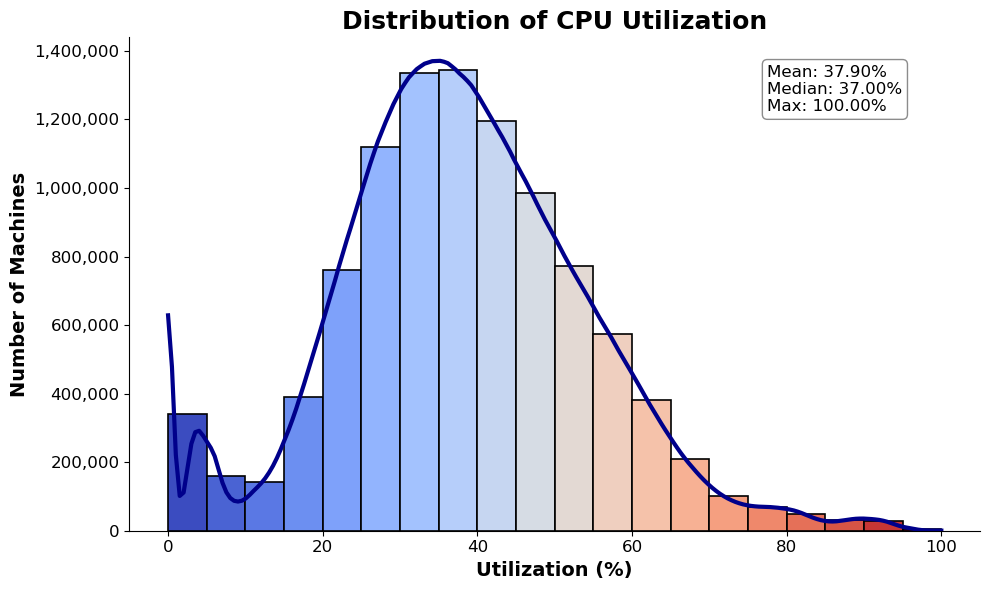

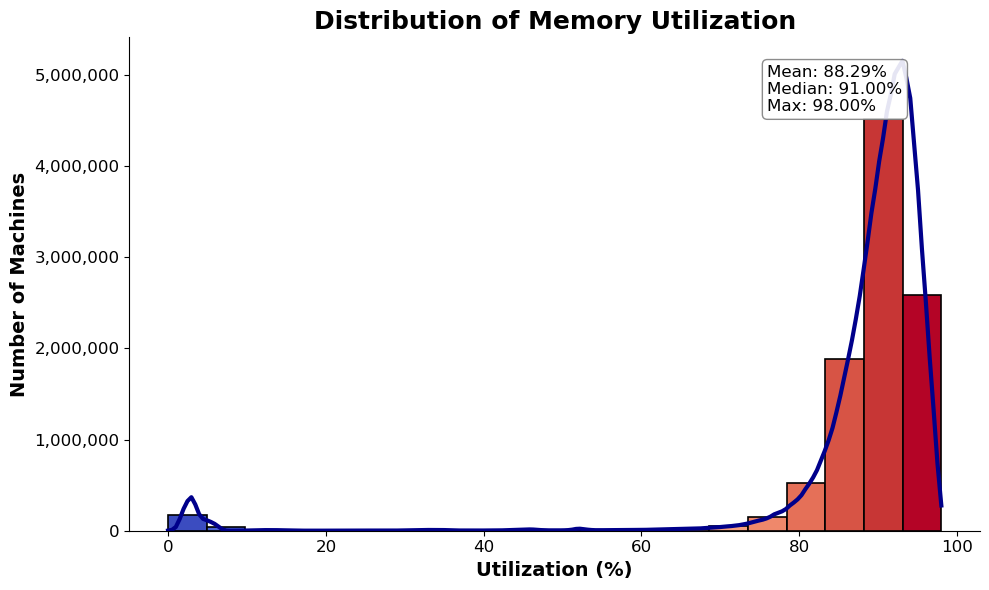

In [50]:
def plot_resource_util(df, col_name):
   plt.style.use('default')
   fig, ax = plt.subplots(figsize=(10, 6), dpi=100, facecolor='white')
   ax.set_facecolor('white')
   gradient = np.linspace(0, 1, 20)
   cmap = plt.cm.coolwarm
   n, bins, patches = ax.hist(df[col_name], bins=20, edgecolor='black', linewidth=1.2)
   for g, p in zip(gradient, patches):
       plt.setp(p, 'facecolor', cmap(g))
   kde_x = np.linspace(df[col_name].min(), df[col_name].max(), 200)
   kde = stats.gaussian_kde(df[col_name].dropna())
   kde_y = kde(kde_x) * len(df[col_name]) * (bins[1] - bins[0])
   ax.plot(kde_x, kde_y, color='darkblue', linewidth=3)
   stats_text = f"Mean: {df[col_name].mean():.2f}%\nMedian: {df[col_name].median():.2f}%\nMax: {df[col_name].max():.2f}%"
   ax.text(0.75, 0.85, stats_text, transform=ax.transAxes, fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
   title = f"Distribution of CPU Utilization" if col_name[:3] == 'cpu' else f"Distribution of Memory Utilization"
   ax.set_title(title, fontsize=18, fontweight='bold')
   ax.set_ylabel("Number of Machines", fontsize=14, fontweight='bold')
   ax.set_xlabel("Utilization (%)", fontsize=14, fontweight='bold')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.tick_params(axis='both', labelsize=12)
   ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
   ax.grid(False)
   plt.tight_layout()
   plt.savefig(f'alibaba_{col_name}_distribution.png', dpi=300, bbox_inches='tight')
   return fig, ax

plot_resource_util(machine_usage, 'cpu_util_percent')
plot_resource_util(machine_usage, 'mem_util_percent')

In [ ]:
task_type_resource_util = batch_instance.groupby('task_type')[['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']].mean()
task_type_resource_util = task_type_resource_util.dropna()
task_type_resource_util

,cpu_avg,cpu_max,mem_avg,mem_max
task_type,,,,
1,0.610946,1.219036,0.108809,0.139747
3,0.768725,1.054004,0.041274,0.053690
4,0.102464,0.389420,0.040145,0.045797
6,0.161785,0.353880,0.020208,0.020978
8,0.423708,1.188524,0.130552,0.192390
9,0.839413,3.085573,0.139183,0.176315
10,0.706740,0.873049,0.052716,0.058338
11,0.781700,3.607632,0.075871,0.105504
12,0.772662,0.971840,0.137854,0.160420


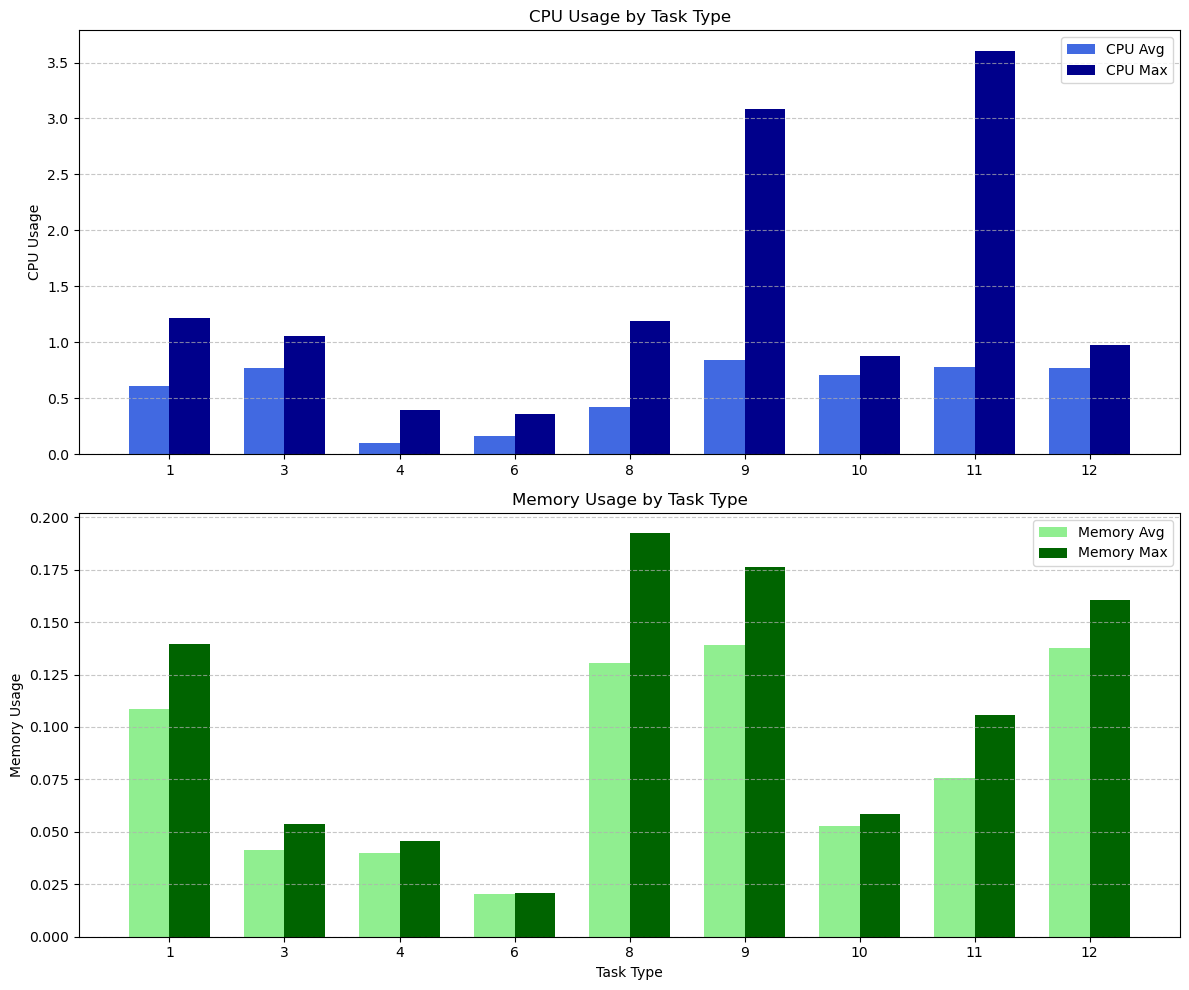

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
x = np.arange(len(task_type_resource_util.index))
width = 0.35

ax1.bar(x - width/2, task_type_resource_util['cpu_avg'], width, label='CPU Avg', color='royalblue')
ax1.bar(x + width/2, task_type_resource_util['cpu_max'], width, label='CPU Max', color='darkblue')
ax1.set_ylabel('CPU Usage')
ax1.set_title('CPU Usage by Task Type')
ax1.set_xticks(x)
ax1.set_xticklabels(task_type_resource_util.index)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.bar(x - width/2, task_type_resource_util['mem_avg'], width, label='Memory Avg', color='lightgreen')
ax2.bar(x + width/2, task_type_resource_util['mem_max'], width, label='Memory Max', color='darkgreen')
ax2.set_xlabel('Task Type')
ax2.set_ylabel('Memory Usage')
ax2.set_title('Memory Usage by Task Type')
ax2.set_xticks(x)
ax2.set_xticklabels(task_type_resource_util.index)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('alibaba_task_resource_usage.png')
plt.show()

In [ ]:
batch_instance_utilization = batch_instance.groupby('machine_id')[['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']].mean()
batch_instance_utilization.head()

,cpu_avg,cpu_max,mem_avg,mem_max
machine_id,,,,
m_1,32.833333,93.166667,0.030000,0.035000
m_10,85.500000,150.000000,0.055000,0.075000
m_100,8.000000,58.500000,0.020000,0.020000
m_1000,46.000000,99.666667,0.053333,0.076667
m_1001,63.333333,170.333333,0.076667,0.086667


,machine_id,time_stamp,failure_domain_1,failure_domain_2,cpu_num,mem_size,status
